In [ ]:
# Copyright 2021 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Step by Step Guide to Building Reinforcement Learning Applications using Vertex AI

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/tree/master/community-content/tf_agents_bandits_movie_recommendation_with_kfp_and_vertex_sdk/step_by_step_sdk_tf_agents_bandits_movie_recommendation/step_by_step_sdk_tf_agents_bandits_movie_recommendation.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/tree/master/community-content/tf_agents_bandits_movie_recommendation_with_kfp_and_vertex_sdk/step_by_step_sdk_tf_agents_bandits_movie_recommendation/step_by_step_sdk_tf_agents_bandits_movie_recommendation.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
</table>

## Overview
This demo showcases the use of [TF-Agents](https://www.tensorflow.org/agents) and [Vertex AI](https://cloud.google.com/vertex-ai) in building a movie recommendation system with reinforcement learning. The demo is intended for developers interested in creating reinforcement learning applications using TensorFlow and the TF-Agents library, leveraging Vertex AI services (including custom training, custom prediction, model deployment over managed endpoints, and prediction fetching). It is recommended for developers to have familiarity with basic reinforcement learning theory, particularly the contextual bandits formulation, and the TF-Agents interface. Note that contextual bandits form a special case of RL, where the actions taken by the agent do not alter the state of the environment. “Contextual” refers to the fact that the agent chooses among a set of actions while having knowledge of the context (environment observation).

### Dataset
This demo uses the [MovieLens 100K](https://www.kaggle.com/prajitdatta/movielens-100k-dataset) dataset to simulate an environment with users and their respective preferences. It is available at `gs://cloud-samples-data/vertex-ai/community-content/tf_agents_bandits_movie_recommendation_with_kfp_and_vertex_sdk/u.data`.

### Objective
In this notebook, you will learn how to build a TF-Agents (particularly the bandits module) based reinforcement application using the custom training, custom prediction and endpoint deployment services of Vertex AI.
For custom training, you will implement on-policy training, in which you actively interact with a simulation environment based on MovieLens to (1) obtain environment observations, (2) choose actions using the data-collecting policy given the observations, and (3) obtain environment feedback in the form of rewards that correspond to (1)(2). These pieces of data form the training data records. This process is different from off-policy training, where you do not necessarily have training data asscociated with the actual actions outputted by the policy.

This demo consists of 2 main steps:
1. Run locally with a [TF-Agents](https://www.tensorflow.org/agents) implementation.
2. Execute in [Vertex AI](https://cloud.google.com/vertex-ai).

In addition to the training, prediction and prediction workflow, the demo also showcases the following optimizations:
1. Hyperparameter tuning with Vertex AI
2. Profiling of the training process and resources with TensorBoard Profiler, which can inform designs for purposes like speed improvements, scaling

This demo references code from [this TF-Agents example](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/agents/examples/v2/train_eval_movielens.py), [this Vertex AI SDK custom container training example](https://github.com/GoogleCloudPlatform/ai-platform-samples/blob/master/ai-platform-unified/notebooks/unofficial/sdk/AI_Platform_(Unified)_SDK_BigQuery_Custom_Container_Training.ipynb), and [this Vertex AI SDK custom container prediction example](https://github.com/GoogleCloudPlatform/ai-platform-samples/blob/master/ai-platform-unified/notebooks/unofficial/sdk/AI_Platform_(Unified)_SDK_Custom_Container_Prediction.ipynb).

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Build
* Cloud Storage
* Container Registry

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing), [Cloud Build pricing](https://cloud.google.com/build/pricing), [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and [Container Registry pricing](https://cloud.google.com/container-registry/pricing) use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

### Set up your local development environment

**If you are using Colab or Google Cloud Notebooks**, your environment already meets
all the requirements to run this notebook. You can skip this step.

**Otherwise**, make sure your environment meets this notebook's requirements.
You need the following:

* The Google Cloud SDK
* Git
* Python 3
* virtualenv
* Jupyter notebook running in a virtual environment with Python 3

The Google Cloud guide to [Setting up a Python development
environment](https://cloud.google.com/python/setup) and the [Jupyter
installation guide](https://jupyter.org/install) provide detailed instructions
for meeting these requirements. The following steps provide a condensed set of
instructions:

1. [Install and initialize the Cloud SDK.](https://cloud.google.com/sdk/docs/)

1. [Install Python 3.](https://cloud.google.com/python/setup#installing_python)

1. [Install
   virtualenv](https://cloud.google.com/python/setup#installing_and_using_virtualenv)
   and create a virtual environment that uses Python 3. Activate the virtual environment.

1. To install Jupyter, run `pip3 install jupyter` on the
command-line in a terminal shell.

1. To launch Jupyter, run `jupyter notebook` on the command-line in a terminal shell.

1. Open this notebook in the Jupyter Notebook Dashboard.

### Install additional packages

Install additional package dependencies not installed in your notebook environment, such as the AI Platform SDK and TF-Agents. Use the latest major GA version of each package.

In [1]:
import os

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

# Google Cloud Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_GOOGLE_CLOUD_NOTEBOOK:
    USER_FLAG = "--user"

In [6]:
VERSION='v1'

In [3]:
# ! pip3 install {USER_FLAG} google-cloud-aiplatform
# ! pip3 install {USER_FLAG} google-cloud-storage
# ! pip3 install {USER_FLAG} numpy
# ! pip3 install {USER_FLAG} cloudml-hypertune
# ! pip3 install {USER_FLAG} --upgrade tensorflow
# ! pip3 install {USER_FLAG} --upgrade pillow
# ! pip3 install {USER_FLAG} --upgrade tf-agents
# ! pip3 install {USER_FLAG} --upgrade tensorboard-plugin-profile

### Restart the kernel

After you install the additional packages, you need to restart the notebook kernel so it can find the packages.

In [4]:
# Automatically restart kernel after installs
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

## Before you begin

### Select a GPU runtime

**Make sure you're running this notebook in a GPU runtime if you have that option. In Colab, select "Runtime --> Change runtime type > GPU"**

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI API, Cloud Build API, Cloud Storage API, and Container Registry API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,cloudbuild.googleapis.com,storage.googleapis.com,containerregistry.googleapis.com).

1. If you are running this notebook locally, you will need to install the [Cloud SDK](https://cloud.google.com/sdk).

1. Enter your project ID in the cell below. Then run the cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

#### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`.

In [1]:
import os

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)

Project ID:  hybrid-vertex


Otherwise, set your project ID here.

In [2]:
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append it onto the name of resources you create in this tutorial.

In [3]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Authenticate your Google Cloud account

**If you are using Google Cloud Notebooks**, your environment is already
authenticated. Skip this step.

**If you are using Colab**, run the cell below and follow the instructions
when prompted to authenticate your account via oAuth.

**Otherwise**, follow these steps:

1. In the Cloud Console, go to the [**Create service account key**
   page](https://console.cloud.google.com/apis/credentials/serviceaccountkey).

2. Click **Create service account**.

3. In the **Service account name** field, enter a name, and
   click **Create**.

4. In the **Grant this service account access to project** section, click the **Role** drop-down list. Type "Vertex AI"
into the filter box, and select
   **Vertex AI Administrator**. Type "Storage Object Admin" into the filter box, and select **Storage Object Admin**.

5. Click *Create*. A JSON file that contains your key downloads to your
local environment.

6. Enter the path to your service account key as the
`GOOGLE_APPLICATION_CREDENTIALS` variable in the cell below and run the cell.

In [4]:
import os
import sys

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

# If on Google Cloud Notebooks, then don't execute this code
if not IS_GOOGLE_CLOUD_NOTEBOOK:
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth
        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**

In this tutorial, a Cloud Storage bucket holds the MovieLens dataset files to be used for model
training. Vertex AI also saves the trained model that results from your training job in the same
bucket. Using this model artifact, you can then create Vertex AI model and endpoint resources in
order to serve online predictions.

Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets.

You may also change the `REGION` variable, which is used for operations
throughout the rest of this notebook. Make sure to [choose a region where Vertex AI services are
available](https://cloud.google.com/vertex-ai/docs/general/locations#available_regions). You may
not use a Multi-Regional Storage bucket for training with Vertex AI.

In [7]:
BUCKET_NAME = f"gs://tf-agents-bandits-{VERSION}"  # @param {type:"string"} The bucket should be in same region as uCAIP. The bucket should not be multi-regional for custom training jobs to work.
REGION = "us-central1"  # @param {type:"string"}

In [8]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "gs://[your-bucket-name]":
    BUCKET_NAME = "gs://" + PROJECT_ID + "aip-" + TIMESTAMP

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [14]:
! gsutil mb -l $REGION $BUCKET_NAME

Creating gs://tf-agents-bandits-v1/...


Finally, validate access to your Cloud Storage bucket by examining its contents:

In [9]:
! gsutil ls -al $BUCKET_NAME

                                 gs://tf-agents-bandits-v1/artifacts/


### Import libraries and define constants

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [11]:
import functools
import json
import os
from collections import defaultdict
from typing import Callable, Dict, List, Optional, TypeVar

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from google.cloud import aiplatform, storage

from tf_agents.agents import TFAgent
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.agents.examples.v2 import trainer
from tf_agents.bandits.environments import (environment_utilities,
                                            movielens_py_environment)
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import TFEnvironment, tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.metrics.tf_metric import TFStepMetric
from tf_agents.policies import policy_saver

if tf.__version__[0] != "2":
    raise Exception("The trainer only runs with TensorFlow version 2.")

T = TypeVar("T")

In [12]:
ROOT_DIR = f"{BUCKET_NAME}/artifacts"  # @param {type:"string"} Root directory for writing logs/summaries/checkpoints.
ARTIFACTS_DIR = f"{BUCKET_NAME}/artifacts"  # @param {type:"string"} Where the trained model will be saved and restored.
PROFILER_DIR = f"{BUCKET_NAME}/profiler"  # @param {type:"string"} Directory for TensorBoard Profiler artifacts.
DATA_PATH = f"{BUCKET_NAME}/artifacts/u.data"  # Location of the MovieLens 100K dataset's "u.data" file.
RAW_BUCKET_NAME = BUCKET_NAME[5:]  # Remove the prefix `gs://`.

In [13]:
# Copy the sample data into your DATA_PATH
! gsutil cp "gs://cloud-samples-data/vertex-ai/community-content/tf_agents_bandits_movie_recommendation_with_kfp_and_vertex_sdk/u.data"  $DATA_PATH

Copying gs://cloud-samples-data/vertex-ai/community-content/tf_agents_bandits_movie_recommendation_with_kfp_and_vertex_sdk/u.data [Content-Type=application/octet-stream]...
/ [1 files][  1.9 MiB/  1.9 MiB]                                                
Operation completed over 1 objects/1.9 MiB.                                      


In [14]:
# Set hyperparameters.
BATCH_SIZE = 8  # @param {type:"integer"} Training and prediction batch size.
TRAINING_LOOPS = 5  # @param {type:"integer"} Number of training iterations.
STEPS_PER_LOOP = 2  # @param {type:"integer"} Number of driver steps per training iteration.

# Set MovieLens simulation environment parameters.
RANK_K = 20  # @param {type:"integer"} Rank for matrix factorization in the MovieLens environment; also the observation dimension.
NUM_ACTIONS = 20  # @param {type:"integer"} Number of actions (movie items) to choose from.
PER_ARM = False  # Use the non-per-arm version of the MovieLens environment.

# Set agent parameters.
TIKHONOV_WEIGHT = 0.001  # @param {type:"number"} LinUCB Tikhonov regularization weight.
AGENT_ALPHA = 10.0  # @param {type:"number"} LinUCB exploration parameter that multiplies the confidence intervals.

## Implement and execute locally (optional)

### Define RL modules [locally]

Define a [MovieLens-specific bandits environment](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/environments/movielens_py_environment/MovieLensPyEnvironment), a [Linear UCB agent](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/lin_ucb_agent) and the [regret metric](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/metrics/tf_metrics/RegretMetric).

In [15]:
# Define RL environment.
env = movielens_py_environment.MovieLensPyEnvironment(
    DATA_PATH, RANK_K, BATCH_SIZE, num_movies=NUM_ACTIONS, csv_delimiter="\t")
environment = tf_py_environment.TFPyEnvironment(env)

# Define RL agent/algorithm.
agent = lin_ucb_agent.LinearUCBAgent(
    time_step_spec=environment.time_step_spec(),
    action_spec=environment.action_spec(),
    tikhonov_weight=TIKHONOV_WEIGHT,
    alpha=AGENT_ALPHA,
    dtype=tf.float32,
    accepts_per_arm_features=PER_ARM)
print("TimeStep Spec (for each batch):\n", agent.time_step_spec, "\n")
print("Action Spec (for each batch):\n", agent.action_spec, "\n")
print("Reward Spec (for each batch):\n", environment.reward_spec(), "\n")

# Define RL metric.
optimal_reward_fn = functools.partial(
    environment_utilities.compute_optimal_reward_with_movielens_environment,
    environment=environment)
regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward_fn)
metrics = [regret_metric]

2023-07-03 14:45:37.683228: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-03 14:45:37.685354: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-03 14:45:37.696471: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

TimeStep Spec (for each batch):
 TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': TensorSpec(shape=(20,), dtype=tf.float64, name='observation'),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')}) 

Action Spec (for each batch):
 BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(19, dtype=int32)) 

Reward Spec (for each batch):
 TensorSpec(shape=(), dtype=tf.float32, name='reward') 



s-bus-pci#L344-L355
2023-07-03 14:45:37.700590: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-03 14:45:37.702552: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-03 14:45:38.434763: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentat

### Train the model [locally]

Define the training logic (on-policy training). The following function is the same as [trainer.train](https://github.com/tensorflow/agents/blob/r0.8.0/tf_agents/bandits/agents/examples/v2/trainer.py#L104), but it keeps track of intermediate metric values and saves different artifacts to different locations. You can also directly invoke [trainer.train](https://github.com/tensorflow/agents/blob/r0.8.0/tf_agents/bandits/agents/examples/v2/trainer.py#L104) which also trains the policy.

In [29]:
def train(
    root_dir: str,
    agent: TFAgent,
    environment: TFEnvironment,
    training_loops: int,
    steps_per_loop: int,
    additional_metrics: Optional[List[TFStepMetric]] = None,
    training_data_spec_transformation_fn: Optional[Callable[[T], T]] = None,
) -> Dict[str, List[float]]:
    """Performs `training_loops` iterations of training on the agent's policy.

    Uses the `environment` as the problem formulation and source of immediate
    feedback and the agent's algorithm, to perform `training-loops` iterations
    of on-policy training on the policy.
    If one or more baseline_reward_fns are provided, the regret is computed
    against each one of them. Here is example baseline_reward_fn:
    def baseline_reward_fn(observation, per_action_reward_fns):
        rewards = ... # compute reward for each arm
        optimal_action_reward = ... # take the maximum reward
        return optimal_action_reward

    Args:
        root_dir: Path to the directory where training artifacts are written.
        agent: An instance of `TFAgent`.
        environment: An instance of `TFEnvironment`.
        training_loops: An integer indicating how many training loops should be run.
        steps_per_loop: An integer indicating how many driver steps should be
           executed and presented to the trainer during each training loop.
        additional_metrics: Optional; list of metric objects to log, in addition to
          default metrics `NumberOfEpisodes`, `AverageReturnMetric`, and
          `AverageEpisodeLengthMetric`.
        training_data_spec_transformation_fn: Optional; function that transforms
          the data items before they get to the replay buffer.

    Returns:
        A dict mapping metric names (eg. "AverageReturnMetric") to a list of
        intermediate metric values over `training_loops` iterations of training.
    """
    if training_data_spec_transformation_fn is None:
        data_spec = agent.policy.trajectory_spec
    else:
        data_spec = training_data_spec_transformation_fn(
            agent.policy.trajectory_spec)
    replay_buffer = trainer._get_replay_buffer(
        data_spec
        , environment.batch_size
        ,steps_per_loop
        , 1
    )

    # `step_metric` records the number of individual rounds of bandit interaction;
    # that is, (number of trajectories) * batch_size.
    step_metric = tf_metrics.EnvironmentSteps()
    metrics = [
        tf_metrics.NumberOfEpisodes(),
        tf_metrics.AverageEpisodeLengthMetric(batch_size=environment.batch_size)
    ]
    if additional_metrics:
        metrics += additional_metrics

    if isinstance(environment.reward_spec(), dict):
        metrics += [tf_metrics.AverageReturnMultiMetric(
            reward_spec=environment.reward_spec(),
            batch_size=environment.batch_size)]
    else:
        metrics += [
            tf_metrics.AverageReturnMetric(batch_size=environment.batch_size)]

    # Store intermediate metric results, indexed by metric names.
    metric_results = defaultdict(list)

    if training_data_spec_transformation_fn is not None:
        def add_batch_fn(data): return replay_buffer.add_batch(training_data_spec_transformation_fn(data)) 
        
    else:
        add_batch_fn = replay_buffer.add_batch

    observers = [add_batch_fn, step_metric] + metrics

    driver = dynamic_step_driver.DynamicStepDriver(
        env=environment,
        policy=agent.collect_policy,
        num_steps=steps_per_loop * environment.batch_size,
        observers=observers)

    # training_loop = trainer.get_training_loop_fn(
    training_loop = trainer._get_training_loop(        # jt TODO
        driver=driver
        , replay_buffer=replay_buffer
        , agent=agent
        , steps=steps_per_loop
        , async_steps_per_loop=1
    )
    saver = policy_saver.PolicySaver(agent.policy)

    # for _ in range(training_loops):
    for train_step in range(training_loops):
        training_loop(    # JT TODO
            train_step=train_step
            , metrics=metrics
        )
        metric_utils.log_metrics(metrics)
        for metric in metrics:
            metric.tf_summaries(train_step=step_metric.result())
            metric_results[type(metric).__name__].append(metric.result().numpy())
    saver.save(root_dir)
    return metric_results

Train the RL policy and gather intermediate metric results. At the same time, use [TensorBoard Profiler](https://www.tensorflow.org/guide/profiler) to profile the training process and resources.

In [28]:
tf.profiler.experimental.stop()

2023-07-03 15:05:56.561089: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2023-07-03 15:05:56.561684: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1813] CUPTI activity buffer flushed
2023-07-03 15:05:56.618174: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_collector.cc:541]  GpuTracer has collected 10 callback api events and 10 activity events. 
2023-07-03 15:05:56.622006: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


In [30]:
tf.profiler.experimental.start(PROFILER_DIR)

metric_results = train(
    root_dir=ROOT_DIR,
    agent=agent,
    environment=environment,
    training_loops=TRAINING_LOOPS,
    steps_per_loop=STEPS_PER_LOOP,
    additional_metrics=metrics
)

tf.profiler.experimental.stop()

2023-07-03 15:06:02.169085: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-07-03 15:06:02.169130: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2023-07-03 15:06:04.595149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'arg_0' with dtype int32 and shape [8]
	 [[{{node arg_0}}]]
2023-07-03 15:06:04.595277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'arg_0_3' with dtype int32 and shape [8]
	 [[{{node arg_0_3}}]]


2023-07-03 15:06:05.876833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype resource
	 [[{{node Placeholder/_8}}]]
2023-07-03 15:06:05.877194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype resource
	 [[{{node Placeholder/_12}}]]
2023-07-03 15:06:07.081751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype resource
	 [[{{node Placeholder/_12}}]]
2023-07-0

INFO:tensorflow:Assets written to: gs://tf-agents-bandits-v1/artifacts/assets


INFO:tensorflow:Assets written to: gs://tf-agents-bandits-v1/artifacts/assets
2023-07-03 15:06:15.946800: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2023-07-03 15:06:15.952745: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1813] CUPTI activity buffer flushed
2023-07-03 15:06:16.699966: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_collector.cc:541]  GpuTracer has collected 126279 callback api events and 125771 activity events. 
2023-07-03 15:06:17.441346: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


### Evaluate RL metrics [locally]

You can visualize how the regret and average return metrics evolve over training steps.

In [31]:
def plot(metric_results, metric_name):
    plt.plot(metric_results[metric_name])
    plt.ylabel(metric_name)
    plt.xlabel("Step")
    plt.title("{} versus Step".format(metric_name))

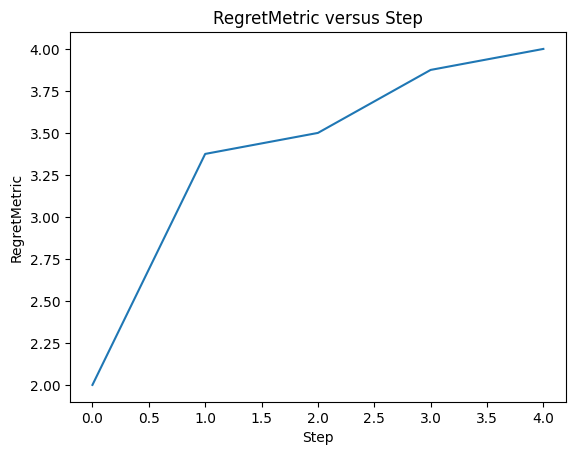

In [32]:
plot(metric_results, "RegretMetric")

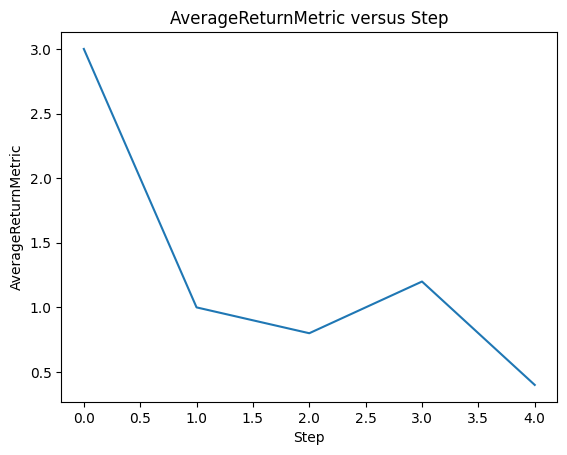

In [33]:
plot(metric_results, "AverageReturnMetric")

### Profile training [optional]

Load [TensorBoard Profiler](https://www.tensorflow.org/guide/profiler) artifacts for the training process and resources. Visualize information such as operation statistics on different devices, operation tracing, and so on [1]. These pieces of information can enable you to identitfy bottlenecks in training performance and can inform you on potential improvements in speed and/or scalability.

In [34]:
# # If on Google Cloud Notebooks, then don't execute this code.
# if not IS_GOOGLE_CLOUD_NOTEBOOK:
#     if "google.colab" in sys.modules:

#         # Load the TensorBoard notebook extension.
#         %load_ext tensorboard

In [35]:
# # If on Google Cloud Notebooks, then don't execute this code.
# if not IS_GOOGLE_CLOUD_NOTEBOOK:
#     if "google.colab" in sys.modules:

#         %tensorboard --logdir $PROFILER_DIR

[1] For Google Cloud Notebooks, you can do the following:

1. Open [Cloud Shell](https://cloud.google.com/shell) from the GCP Console.
2. Install dependencies: `pip3 install tensorflow==2.5.0 tensorboard-plugin-profile==2.5.0`.
3. Run the following command: `tensorboard --logdir <PROFILER_DIR>`. You will see a message "TensorBoard 2.5.0 at http://localhost:<PORT\>/ (Press CTRL+C to quit)" as the output. Take note of the port number.
4. You can click on the [Web Preview](https://cloud.google.com/shell/docs/using-web-preview) button and view the TensorBoard dashboard and profiling results. You need to configure Web Preview's port to be the same port as you receive from step 3.

In [39]:
PROFILER_DIR

'gs://tf-agents-bandits-v1/profiler'

In [37]:
%load_ext tensorboard
# %reload_ext tensorboard

In [38]:
%tensorboard --logdir=$PROFILER_DIR
# tensorboard --logdir=gs://tf-agents-bandits-v1/profiler

## Execute in Vertex AI

This section consists of the following steps:
1.   Run unit tests on `policy_util` and `task` modules
2.   Create hyperparameter tuning and training custom container
3.   Submit hyperparameter tuning job [optional]
4.   Create custom prediction container
5.   Submit custom container training job
6.   Deploy trained model to Endpoint
7.   Predict on the Endpoint

### Run unit tests on `policy_util` and `task` modules

Run unit tests on the modules in `src/training/`.

Locate the tests in `src/tests/`, and fill in the configurations that are marked with "FILL IN" in the test files.

In [56]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [57]:
import gc
gc.collect()

14

In [112]:
# ! python3 -m unittest src/tests/test_policy_util.py

In [113]:
# ! python3 -m unittest src/tests/test_task.py

### Create hyperparameter tuning and training custom container

Create a custom container that can be used for both hyperparameter tuning and training. The associated source code is in `src/training/`. This serves as the inner script of the custom container.
As before, the training function is the same as [trainer.train](https://github.com/tensorflow/agents/blob/r0.8.0/tf_agents/bandits/agents/examples/v2/trainer.py#L104), but it keeps track of intermediate metric values, supports hyperparameter tuning, and (for training) saves artifacts to different locations. The training logic for hyperparameter tuning and training is the same.

#### Execute hyperparameter tuning:
- The code does not save model artifacts. It takes in command-line arguments as hyperparameter values from the Vertex AI Hyperparameter Tuning service, and reports training result metric to Vertex AI at each trial using cloudml-hypertune.
- Note that if you decide to save model artifacts, saving them to the same directory may cause overwriting errors if you use parallel trials in the hyperparameter tuning job. The recommended approach is to save each trial's artifacts to a different sub-directory. This would also allow you to recover all the artifacts from different trials and can potentially save you from re-training.
- Read more about hyperparameter tuning for custom containers [here](https://cloud.google.com/vertex-ai/docs/training/containers-overview#hyperparameter_tuning_with_custom_containers); read about hyperparameter tuning support [here](https://cloud.google.com/vertex-ai/docs/training/hyperparameter-tuning-overview).

#### Execute training:
- The code saves model artifacts to `os.environ["AIP_MODEL_DIR"]` in addition to `ARTIFACTS_DIR`, as required [here](https://github.com/googleapis/python-aiplatform/blob/v0.8.0/google/cloud/aiplatform/training_jobs.py#L2202).
- If you want to make changes to the function, make sure to still save the trained policy as a SavedModel to clean directories, and avoid saving checkpoints and other artifacts, so that deploying the model to endpoints works.

In [42]:
HPTUNING_TRAINING_CONTAINER = "hptuning-training-custom-container"  # @param {type:"string"} Name of the container image.

#### Create a Cloud Build YAML file

Use [Kaniko](https://github.com/GoogleContainerTools/kaniko) to build the hyperparameter-tuning/training container. You can apply caching and specify the build machine type. Alternatively, you can also use Docker build.

In [43]:
cloudbuild_yaml = """steps:
- name: 'gcr.io/kaniko-project/executor:latest'
  args: ['--destination=gcr.io/{PROJECT_ID}/{HPTUNING_TRAINING_CONTAINER}:latest',
         '--cache=true',
         '--cache-ttl=99h']
options:
  machineType: 'E2_HIGHCPU_8'""".format(
    PROJECT_ID=PROJECT_ID,
    HPTUNING_TRAINING_CONTAINER=HPTUNING_TRAINING_CONTAINER,
)

with open("cloudbuild.yaml", "w") as fp:
    fp.write(cloudbuild_yaml)

#### Write a Dockerfile

- Use the [cloudml-hypertune](https://github.com/GoogleCloudPlatform/cloudml-hypertune) Python package to report training metrics to Vertex AI for hyperparameter tuning.
- Use the Google [Cloud Storage client library](https://cloud.google.com/storage/docs/reference/libraries) to read the best hyperparameters learned from a previous hyperarameter tuning job during training.

In [70]:
%%writefile Dockerfile

# Specifies base image and tag.
FROM gcr.io/google-appengine/python
WORKDIR /root

# Installs additional packages.
RUN pip3 install cloudml-hypertune==0.1.0.dev6
RUN pip3 install google-cloud-storage==1.39.0
RUN pip3 install tensorflow==2.5.0
RUN pip3 install tensorboard-plugin-profile==2.5.0
RUN pip3 install tf-agents==0.8.0
RUN pip3 install matplotlib==3.4.2
RUN pip3 install urllib3==1.26.6 

####
# google-cloud-aiplatform>=1.26.1
# tensorflow-recommenders==0.7.2
# tensorboard==2.10.1
# tensorboard-data-server==0.6.1
# tensorboard-plugin-profile==2.11.1
# tensorflow-io==0.27.0
# google-cloud-aiplatform[cloud_profiler]>=1.26.1

# Copies training code to the Docker image.
COPY src/training /root/src/training

# Sets up the entry point to invoke the task.
ENTRYPOINT ["python3", "-m", "src.training.task"]

Overwriting Dockerfile


#### Build the custom container with Cloud Build

In [71]:
! gcloud builds submit --config cloudbuild.yaml

Creating temporary tarball archive of 17 file(s) totalling 398.3 KiB before compression.
Uploading tarball of [.] to [gs://hybrid-vertex_cloudbuild/source/1688399007.550035-0f50253998ca461580227dd56dec7cc4.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/hybrid-vertex/locations/global/builds/55af5934-80f2-476f-8d16-3ae5c6527d9f].
Logs are available at [ https://console.cloud.google.com/cloud-build/builds/55af5934-80f2-476f-8d16-3ae5c6527d9f?project=934903580331 ].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "55af5934-80f2-476f-8d16-3ae5c6527d9f"

FETCHSOURCE
Fetching storage object: gs://hybrid-vertex_cloudbuild/source/1688399007.550035-0f50253998ca461580227dd56dec7cc4.tgz#1688399007788579
Copying gs://hybrid-vertex_cloudbuild/source/1688399007.550035-0f50253998ca461580227dd56dec7cc4.tgz#1688399007788579...
/ [1 files][157.1 KiB/157.1 KiB]                                                
Operation completed over 1 objects/15

### Submit hyperparameter tuning job [optional]

- Submit a hyperparameter training job with the custom container. Read more details for using Python packages as an alternative to using custom containers in the example shown [here](https://cloud.google.com/vertex-ai/docs/training/using-hyperparameter-tuning#create).
- Define the hyperparameter(s), max trial count, parallel trial count, parameter search algorithm, machine spec, accelerators, worker pool, etc.

In [72]:
RUN_HYPERPARAMETER_TUNING = True  # Execute hyperparameter tuning instead of regular training.
TRAIN_WITH_BEST_HYPERPARAMETERS = False  # Do not train.

HPTUNING_RESULT_DIR = "hptuning/"  # @param {type: "string"} Directory to store the best hyperparameter(s) in `BUCKET_NAME` and locally (temporarily).
HPTUNING_RESULT_PATH = os.path.join(HPTUNING_RESULT_DIR, "result.json")  # @param {type: "string"} Path to the file containing the best hyperparameter(s).

In [73]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_NAME)

In [74]:
def create_hyperparameter_tuning_job_sample(
    project: str,
    display_name: str,
    image_uri: str,
    args: List[str],
    location: str = "us-central1",
    api_endpoint: str = "us-central1-aiplatform.googleapis.com"
) -> None:
    """Creates a hyperparameter tuning job using a custom container.

    Args:
        project: GCP project ID.
        display_name: GCP console display name for the hyperparameter tuning job in
            Vertex AI.
        image_uri: URI to the hyperparameter tuning container image in Container
            Registry.
        args: Arguments passed to the container.
        location: Service location.
        api_endpoint: API endpoint, eg. `<location>-aiplatform.googleapis.com`.

    Returns:
        A string of the hyperparameter tuning job ID.
    """
    # The AI Platform services require regional API endpoints.
    client_options = {"api_endpoint": api_endpoint}
    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    client = aiplatform.gapic.JobServiceClient(client_options=client_options)

    # study_spec
    # Metric based on which to evaluate which combination of hyperparameter(s) to choose
    metric = {
        "metric_id": "final_average_return",  # Metric you report to Vertex AI.
        "goal": aiplatform.gapic.StudySpec.MetricSpec.GoalType.MAXIMIZE,
    }

    # Hyperparameter(s) to tune
    training_loops = {
        "parameter_id": "training-loops",
        "discrete_value_spec": {"values": [4, 16]},
        "scale_type": aiplatform.gapic.StudySpec.ParameterSpec.ScaleType.UNIT_LINEAR_SCALE,
    }
    steps_per_loop = {
        "parameter_id": "steps-per-loop",
        "discrete_value_spec": {"values": [1, 2]},
        "scale_type": aiplatform.gapic.StudySpec.ParameterSpec.ScaleType.UNIT_LINEAR_SCALE,
    }

    # trial_job_spec
    machine_spec = {
        "machine_type": "n1-standard-4",
        "accelerator_type": aiplatform.gapic.AcceleratorType.ACCELERATOR_TYPE_UNSPECIFIED,
        "accelerator_count": None,
    }
    worker_pool_spec = {
        "machine_spec": machine_spec,
        "replica_count": 1,
        "container_spec": {
            "image_uri": image_uri,
            "args": args,
        },
    }

    # hyperparameter_tuning_job
    hyperparameter_tuning_job = {
        "display_name": display_name,
        "max_trial_count": 4,
        "parallel_trial_count": 2,
        "study_spec": {
            "metrics": [metric],
            "parameters": [training_loops, steps_per_loop],
            "algorithm": aiplatform.gapic.StudySpec.Algorithm.RANDOM_SEARCH,
        },
        "trial_job_spec": {"worker_pool_specs": [worker_pool_spec]},
    }
    parent = f"projects/{project}/locations/{location}"

    # Create job
    response = client.create_hyperparameter_tuning_job(
        parent=parent,
        hyperparameter_tuning_job=hyperparameter_tuning_job)
    job_id = response.name.split("/")[-1]
    print("Job ID:", job_id)
    print("Job config:", response)

    return job_id

In [75]:
args = [
    f"--data-path={DATA_PATH}",
    f"--batch-size={BATCH_SIZE}",
    f"--rank-k={RANK_K}",
    f"--num-actions={NUM_ACTIONS}",
    f"--tikhonov-weight={TIKHONOV_WEIGHT}",
    f"--agent-alpha={AGENT_ALPHA}",
]
if RUN_HYPERPARAMETER_TUNING:
    args.append("--run-hyperparameter-tuning")
elif TRAIN_WITH_BEST_HYPERPARAMETERS:
    args.append("--train-with-best-hyperparameters")

In [76]:
job_id = create_hyperparameter_tuning_job_sample(
    project=PROJECT_ID,
    display_name="movielens-hyperparameter-tuning-job",
    image_uri=f"gcr.io/{PROJECT_ID}/{HPTUNING_TRAINING_CONTAINER}:latest",
    args=args,
    location=REGION,
    api_endpoint=f"{REGION}-aiplatform.googleapis.com")

Job ID: 838967023131164672
Job config: name: "projects/934903580331/locations/us-central1/hyperparameterTuningJobs/838967023131164672"
display_name: "movielens-hyperparameter-tuning-job"
study_spec {
  metrics {
    metric_id: "final_average_return"
    goal: MAXIMIZE
  }
  parameters {
    discrete_value_spec {
      values: 4
      values: 16
    }
    parameter_id: "training-loops"
    scale_type: UNIT_LINEAR_SCALE
  }
  parameters {
    discrete_value_spec {
      values: 1
      values: 2
    }
    parameter_id: "steps-per-loop"
    scale_type: UNIT_LINEAR_SCALE
  }
  algorithm: RANDOM_SEARCH
}
max_trial_count: 4
parallel_trial_count: 2
trial_job_spec {
  worker_pool_specs {
    container_spec {
      image_uri: "gcr.io/hybrid-vertex/hptuning-training-custom-container:latest"
      args: "--data-path=gs://tf-agents-bandits-v1/artifacts/u.data"
      args: "--batch-size=8"
      args: "--rank-k=20"
      args: "--num-actions=20"
      args: "--tikhonov-weight=0.001"
      args: "--

It will take ~20 minutes to complete.

#### Check hyperparameter tuning job status

- Read more about managing jobs [here](https://cloud.google.com/vertex-ai/docs/training/using-hyperparameter-tuning#manage).

In [77]:
def get_hyperparameter_tuning_job_sample(
    project: str,
    hyperparameter_tuning_job_id: str,
    location: str = "us-central1",
    api_endpoint: str = "us-central1-aiplatform.googleapis.com",
) -> aiplatform.HyperparameterTuningJob:
    """Gets the current status of a hyperparameter tuning job.

    Args:
        project: GCP project ID.
        hyperparameter_tuning_job_id: Hyperparameter tuning job ID.
        location: Service location.
        api_endpoint: API endpoint, eg. `<location>-aiplatform.googleapis.com`.

    Returns:
        Details of the hyperparameter tuning job, such as its running status,
        results of its trials, etc.
    """
    # The AI Platform services require regional API endpoints.
    client_options = {"api_endpoint": api_endpoint}
    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    client = aiplatform.gapic.JobServiceClient(client_options=client_options)
    name = client.hyperparameter_tuning_job_path(
        project=project,
        location=location,
        hyperparameter_tuning_job=hyperparameter_tuning_job_id)
    response = client.get_hyperparameter_tuning_job(name=name)
    return response

In [78]:
import time

trials = None
while True:
    response = get_hyperparameter_tuning_job_sample(
        project=PROJECT_ID,
        hyperparameter_tuning_job_id=job_id,
        location=REGION,
        api_endpoint=f"{REGION}-aiplatform.googleapis.com")
    if response.state.name == 'JOB_STATE_SUCCEEDED':
        print("Job succeeded.\nJob Time:", response.update_time - response.create_time)
        trials = response.trials
        print("Trials:", trials)
        break
    elif response.state.name == "JOB_STATE_FAILED":
        print("Job failed.")
        break
    elif response.state.name == "JOB_STATE_CANCELLED":
        print("Job cancelled.")
        break
    else:
        print(f"Current job status: {response.state.name}.")
    time.sleep(60)

Current job status: JOB_STATE_QUEUED.
Current job status: JOB_STATE_QUEUED.
Current job status: JOB_STATE_QUEUED.
Current job status: JOB_STATE_RUNNING.
Current job status: JOB_STATE_RUNNING.
Current job status: JOB_STATE_RUNNING.
Current job status: JOB_STATE_RUNNING.
Current job status: JOB_STATE_RUNNING.
Current job status: JOB_STATE_RUNNING.
Current job status: JOB_STATE_RUNNING.
Current job status: JOB_STATE_RUNNING.
Current job status: JOB_STATE_RUNNING.
Current job status: JOB_STATE_RUNNING.
Current job status: JOB_STATE_RUNNING.
Current job status: JOB_STATE_RUNNING.
Current job status: JOB_STATE_RUNNING.
Current job status: JOB_STATE_RUNNING.
Current job status: JOB_STATE_RUNNING.
Job succeeded.
Job Time: 0:18:07.045734
Trials: [id: "1"
state: SUCCEEDED
parameters {
  parameter_id: "steps-per-loop"
  value {
    number_value: 2
  }
}
parameters {
  parameter_id: "training-loops"
  value {
    number_value: 16
  }
}
final_measurement {
  step_count: 1
  metrics {
    metric_id:

#### Find the best combination(s) hyperparameter(s) for each metric

In [79]:
if trials:
    # Dict mapping from metric names to the best metric values seen so far
    best_objective_values = dict.fromkeys(
        [metric.metric_id for metric in trials[0].final_measurement.metrics],
        -np.inf)
    # Dict mapping from metric names to a list of the best combination(s) of
    # hyperparameter(s). Each combination is a dict mapping from hyperparameter
    # names to their values.
    best_params = defaultdict(list)
    for trial in trials:
        # `final_measurement` and `parameters` are `RepeatedComposite` objects.
        # Reference the structure above to extract the value of your interest.
        for metric in trial.final_measurement.metrics:
            params = {
                param.parameter_id: param.value for param in trial.parameters}
            if metric.value > best_objective_values[metric.metric_id]:
                best_params[metric.metric_id] = [params]
            elif metric.value == best_objective_values[metric.metric_id]:
                best_params[param.parameter_id].append(params)  # Handle cases where multiple hyperparameter values lead to the same performance.
    print("Best hyperparameter value(s):")
    for metric, params in best_params.items():
        print(f"Metric={metric}: {sorted(params)}")
else:
    print("No hyperparameter tuning job trials found.")

Best hyperparameter value(s):
Metric=final_average_return: [{'steps-per-loop': 1.0, 'training-loops': 16.0}]


#### Convert a combination of best hyperparameter(s) for a metric of interest to JSON

In [80]:
! mkdir $HPTUNING_RESULT_DIR

with open(HPTUNING_RESULT_PATH, "w") as f:
    json.dump(best_params["final_average_return"][0], f)

#### Upload the best hyperparameter(s) to GCS for use in training

In [81]:
storage_client = storage.Client(project=PROJECT_ID)
bucket = storage_client.bucket(RAW_BUCKET_NAME)
blob = bucket.blob(HPTUNING_RESULT_PATH)
blob.upload_from_filename(HPTUNING_RESULT_PATH)

### Create custom prediction container

As with training, create a custom prediction container. This container handles the TF-Agents specific logic that is different from a regular TensorFlow Model. Specifically, it finds the predicted action using a trained policy. The associated source code is in `src/prediction/`.
See other options for Vertex AI predictions [here](https://cloud.google.com/vertex-ai/docs/predictions/getting-predictions).

#### Serve predictions:
- Use [`tensorflow.saved_model.load`](https://www.tensorflow.org/agents/api_docs/python/tf_agents/policies/PolicySaver#usage), instead of [`tf_agents.policies.policy_loader.load`](https://github.com/tensorflow/agents/blob/r0.8.0/tf_agents/policies/policy_loader.py#L26), to load the trained policy, because the latter produces an object of type [`SavedModelPyTFEagerPolicy`](https://github.com/tensorflow/agents/blob/402b8aa81ca1b578ec1f687725d4ccb4115386d2/tf_agents/policies/py_tf_eager_policy.py#L137) whose `action()` is not compatible for use here.
- Note that prediction requests contain only observation data but not reward. This is because: The prediction task is a standalone request that doesn't require prior knowledge of the system state. Meanwhile, end users only know what they observe at the moment. Reward is a piece of information that comes after the action has been made, so the end users would not have knowledge of said reward. In handling prediction requests, you create a [`TimeStep`](https://www.tensorflow.org/agents/api_docs/python/tf_agents/trajectories/TimeStep) object (consisting of `observation`, `reward`, `discount`, `step_type`) using the [`restart()`](https://www.tensorflow.org/agents/api_docs/python/tf_agents/trajectories/restart) function which takes in an `observation`. This function creates the *first* TimeStep in a trajectory of steps, where reward is 0, discount is 1 and step_type is marked as the first timestep. In other words, each prediction request forms the first `TimeStep` in a brand new trajectory.
- For the prediction response, avoid using NumPy-typed values; instead, convert them to native Python values using methods such as [`tolist()`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.tolist.html) as opposed to `list()`.
- There exists a prestart script in `src/prediction`. FastAPI executes this script before starting up the server. The `PORT` environment variable is set to equal `AIP_HTTP_PORT` in order to run FastAPI on the same port expected by Vertex AI.

In [82]:
PREDICTION_CONTAINER = "prediction-custom-container"  # @param {type:"string"} Name of the container image.

#### Create a Cloud Build YAML file

Use [Kaniko](https://github.com/GoogleContainerTools/kaniko) to build the custom prediction container.

In [114]:
cloudbuild_yaml = """steps:
- name: 'gcr.io/kaniko-project/executor:latest'
  args: ['--destination=gcr.io/{PROJECT_ID}/{PREDICTION_CONTAINER}:latest',
         '--cache=false',
         '--cache-ttl=99h']
  env: ['AIP_STORAGE_URI={ARTIFACTS_DIR}']
options:
  machineType: 'E2_HIGHCPU_8'""".format(
    PROJECT_ID=PROJECT_ID,
    PREDICTION_CONTAINER=PREDICTION_CONTAINER,
    ARTIFACTS_DIR=ARTIFACTS_DIR
)

with open("cloudbuild.yaml", "w") as fp:
    fp.write(cloudbuild_yaml)

#### Define dependencies

- Note that the dependencies should be compatiable with one another (eg. tensorflow==2.5.0 requires numpy<=1.19.2).

In [115]:
%%writefile requirements.txt

numpy
six
typing-extensions~=4.6.3
pillow
tf-agents==0.16.0
tensorflow==2.12.0

Overwriting requirements.txt


#### Write a Dockerfile

Note: leave the server directory `app`.

In [116]:
%%writefile Dockerfile

FROM tiangolo/uvicorn-gunicorn-fastapi:python3.10

COPY src/prediction /app
COPY requirements.txt /app/requirements.txt

RUN pip3 install -r /app/requirements.txt

Overwriting Dockerfile


#### Build the prediction container with Cloud Build

In [117]:
! gcloud builds submit --config cloudbuild.yaml

Creating temporary tarball archive of 21 file(s) totalling 425.0 KiB before compression.
Uploading tarball of [.] to [gs://hybrid-vertex_cloudbuild/source/1688406972.461754-48cb017386c44015ba6d9a205da79337.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/hybrid-vertex/locations/global/builds/242712c9-8d53-4d49-a3fe-afdc31eeee24].
Logs are available at [ https://console.cloud.google.com/cloud-build/builds/242712c9-8d53-4d49-a3fe-afdc31eeee24?project=934903580331 ].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "242712c9-8d53-4d49-a3fe-afdc31eeee24"

FETCHSOURCE
Fetching storage object: gs://hybrid-vertex_cloudbuild/source/1688406972.461754-48cb017386c44015ba6d9a205da79337.tgz#1688406972714983
Copying gs://hybrid-vertex_cloudbuild/source/1688406972.461754-48cb017386c44015ba6d9a205da79337.tgz#1688406972714983...
/ [1 files][160.4 KiB/160.4 KiB]                                                
Operation completed over 1 objects/16

### Submit custom container training job

- Note again that the bucket must be in the same regional location as the service location and it should not be multi-regional.
- Read more of CustomContainerTrainingJob's source code [here](https://github.com/googleapis/python-aiplatform/blob/v0.8.0/google/cloud/aiplatform/training_jobs.py#L2153).
- Like with local execution, you can use TensorBoard Profiler to track the training process and resources, and visualize the corresponding artifacts using the command: `%tensorboard --logdir $PROFILER_DIR`.

In [118]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_NAME)

In [119]:
RUN_HYPERPARAMETER_TUNING = False  # Execute regular training instead of hyperparameter tuning.
TRAIN_WITH_BEST_HYPERPARAMETERS = True  # @param {type:"bool"} Whether to use learned hyperparameters in training.

In [120]:
args = [
    f"--artifacts-dir={ARTIFACTS_DIR}",
    f"--profiler-dir={PROFILER_DIR}",
    f"--data-path={DATA_PATH}",
    f"--batch-size={BATCH_SIZE}",
    f"--rank-k={RANK_K}",
    f"--num-actions={NUM_ACTIONS}",
    f"--tikhonov-weight={TIKHONOV_WEIGHT}",
    f"--agent-alpha={AGENT_ALPHA}",
]
if RUN_HYPERPARAMETER_TUNING:
    args.append("--run-hyperparameter-tuning")
elif TRAIN_WITH_BEST_HYPERPARAMETERS:
    args.append("--train-with-best-hyperparameters")
    args.append(f"--best-hyperparameters-bucket={RAW_BUCKET_NAME}")
    args.append(f"--best-hyperparameters-path={HPTUNING_RESULT_PATH}")

In [121]:
job = aiplatform.CustomContainerTrainingJob(
    display_name="train-movielens",
    container_uri=f"gcr.io/{PROJECT_ID}/{HPTUNING_TRAINING_CONTAINER}:latest",
    command=["python3", "-m", "src.training.task"] + args,  # Pass in training arguments, including hyperparameters.
    model_serving_container_image_uri=f"gcr.io/{PROJECT_ID}/{PREDICTION_CONTAINER}:latest",
    model_serving_container_predict_route="/predict",
    model_serving_container_health_route="/health")

print("Training Spec:", job._managed_model)

model = job.run(
    model_display_name="movielens-model",
    replica_count=1,
    machine_type="n1-standard-4",
    accelerator_type="ACCELERATOR_TYPE_UNSPECIFIED",
    accelerator_count=0,
    sync=False
)
    

Training Spec: container_spec {
  image_uri: "gcr.io/hybrid-vertex/prediction-custom-container:latest"
  predict_route: "/predict"
  health_route: "/health"
}

Training Output directory:
gs://tf-agents-bandits-v1/aiplatform-custom-training-2023-07-03-17:59:53.213 


INFO:google.cloud.aiplatform.training_jobs:Training Output directory:
gs://tf-agents-bandits-v1/aiplatform-custom-training-2023-07-03-17:59:53.213 


View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/8335490077866065920?project=934903580331


INFO:google.cloud.aiplatform.training_jobs:View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/8335490077866065920?project=934903580331


CustomContainerTrainingJob projects/934903580331/locations/us-central1/trainingPipelines/8335490077866065920 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:CustomContainerTrainingJob projects/934903580331/locations/us-central1/trainingPipelines/8335490077866065920 current state:
PipelineState.PIPELINE_STATE_RUNNING


View backing custom job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/4168244251571781632?project=934903580331


INFO:google.cloud.aiplatform.training_jobs:View backing custom job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/4168244251571781632?project=934903580331


CustomContainerTrainingJob projects/934903580331/locations/us-central1/trainingPipelines/8335490077866065920 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:CustomContainerTrainingJob projects/934903580331/locations/us-central1/trainingPipelines/8335490077866065920 current state:
PipelineState.PIPELINE_STATE_RUNNING


CustomContainerTrainingJob projects/934903580331/locations/us-central1/trainingPipelines/8335490077866065920 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:CustomContainerTrainingJob projects/934903580331/locations/us-central1/trainingPipelines/8335490077866065920 current state:
PipelineState.PIPELINE_STATE_RUNNING


CustomContainerTrainingJob projects/934903580331/locations/us-central1/trainingPipelines/8335490077866065920 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:CustomContainerTrainingJob projects/934903580331/locations/us-central1/trainingPipelines/8335490077866065920 current state:
PipelineState.PIPELINE_STATE_RUNNING


CustomContainerTrainingJob projects/934903580331/locations/us-central1/trainingPipelines/8335490077866065920 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:CustomContainerTrainingJob projects/934903580331/locations/us-central1/trainingPipelines/8335490077866065920 current state:
PipelineState.PIPELINE_STATE_RUNNING


CustomContainerTrainingJob run completed. Resource name: projects/934903580331/locations/us-central1/trainingPipelines/8335490077866065920


INFO:google.cloud.aiplatform.training_jobs:CustomContainerTrainingJob run completed. Resource name: projects/934903580331/locations/us-central1/trainingPipelines/8335490077866065920


Model available at projects/934903580331/locations/us-central1/models/1011297809879531520


INFO:google.cloud.aiplatform.training_jobs:Model available at projects/934903580331/locations/us-central1/models/1011297809879531520


In [122]:
print("Model display name:", model.display_name)
print("Model ID:", model.name)

Model display name: movielens-model
Model ID: 1011297809879531520


### Deploy trained model to an Endpoint

In [123]:
endpoint = model.deploy(machine_type="n1-standard-4")

Creating Endpoint


INFO:google.cloud.aiplatform.models:Creating Endpoint


Create Endpoint backing LRO: projects/934903580331/locations/us-central1/endpoints/1232081943760207872/operations/6405804427604656128


INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/934903580331/locations/us-central1/endpoints/1232081943760207872/operations/6405804427604656128


Endpoint created. Resource name: projects/934903580331/locations/us-central1/endpoints/1232081943760207872


INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/934903580331/locations/us-central1/endpoints/1232081943760207872


To use this Endpoint in another session:


INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:


endpoint = aiplatform.Endpoint('projects/934903580331/locations/us-central1/endpoints/1232081943760207872')


INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/934903580331/locations/us-central1/endpoints/1232081943760207872')


Deploying model to Endpoint : projects/934903580331/locations/us-central1/endpoints/1232081943760207872


INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/934903580331/locations/us-central1/endpoints/1232081943760207872


Deploy Endpoint model backing LRO: projects/934903580331/locations/us-central1/endpoints/1232081943760207872/operations/6423818826114138112


INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/934903580331/locations/us-central1/endpoints/1232081943760207872/operations/6423818826114138112


Endpoint model deployed. Resource name: projects/934903580331/locations/us-central1/endpoints/1232081943760207872


INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/934903580331/locations/us-central1/endpoints/1232081943760207872


In [124]:
print("Endpoint display name:", endpoint.display_name)
print("Endpoint ID:", endpoint.name)

Endpoint display name: movielens-model_endpoint
Endpoint ID: 1232081943760207872


### Predict on the Endpoint
- Put prediction input(s) into a list named `instances`. The observation should of dimension (BATCH_SIZE, RANK_K). Read more about the MovieLens simulation environment observation [here](https://github.com/tensorflow/agents/blob/v0.8.0/tf_agents/bandits/environments/movielens_py_environment.py#L32-L138).
- Read more about the endpoint prediction API [here](https://cloud.google.com/sdk/gcloud/reference/ai/endpoints/predict).

In [128]:
endpoint.predict(
    instances=[
        {"observation": [list(np.ones(20)) for _ in range(8)]},
    ]
)

Prediction(predictions=[{'PolicyStep 0': [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]}], deployed_model_id='518989279519571968', model_version_id='1', model_resource_name='projects/934903580331/locations/us-central1/models/1011297809879531520', explanations=None)

## Summary

### What exactly is the purpose of the MovieLens simulation environment?

The MovieLens environment *simulates* real-world environment containing users and their respective preferences. Internally, the MovieLens simulation environment takes the user-by-movie-item rating matrix and performs a `RANK_K` matrix factorization on the rating matrix, in order to address the sparsity of the matrix. After this construction step, the environment can generate user vectors of dimension `RANK_K` to represent users in the simulation environment, and is able to determine the approximate reward for any user and movie item pair. In RL's language, user vectors are observations, recommended movie items are actions, and approximate ratings are rewards. This environment therefore defines the RL problem at hand: how to recommend movies that maximize user ratings, in a simulated world of users with their respective preferences defined by the MovieLens dataset, while having zero knowledge of the internal mechanism of the environment.

Note here the user vectors may not be in the same dimension as in the original rating matrix, and the approximate ratings (to address the sparsity of rating data) may not equal the original ratings. The individual entries in the user vectors do not correspond to real-world meanings, such as user age, etc.. In prediction requests, the observations are user vectors that lie in the same space as those generated by the MovieLens simulation environment. In other words, they represent users in the same way as the user vectors/observations generated by the MovieLens environment.

The reason why this demo adopts the MovieLens environment is to base itself on a public dataset without needing to communicate with the real world; such communication adds overhead to the necessary steps of the demo and likely relies on a specific implementation that is difficult to generalize to your production requirements.

### How to apply this demo in production

#### Step 0: Demo

Walk through this demo, which uses the MovieLens simulation environment.

#### Step 1: Offline Simulation

To evaluate the performance of your RL model, you may need to run offline simulation first to determine if your RL model meets production criteria. In this case, you may have a static dataset, similar to the MovieLens dataset but potentially larger, and you can construct a custom simulation environment to use in place of the MovieLens one. In the custom environment, you may decide how to formulate observations and rewards, such as in terms of how to represent users with user vectors and what those vectors look like, perhaps via an embedding layer in a neural network. You may apply the rest of the steps and code in this demo just as you did for MovieLens, and then evaluate your model. After offline simulation, you may proceed to the next-steps of launching your model, such as A/B testing.

#### Step 2: Real-World System

When you deploy the steps in this demo in production, you would replace the MovieLens simulation environment with a real-world system or communication mechanism that binds to the real world. In training, you pull user vectors/observations and ratings/rewards from the real-world environment. Now, the individual entries in the user vectors may have actual meanings such as user age. Again, you may decide how to formulate observations and rewards. In prediction, the observations packaged in prediction requests are again the same kind of user vectors as in training, with the same real-world meanings; you would generate them with the same mechanism.

Your goal for prediction would again be to determine what movie items to recommend for a particular user. You would represent said user with a user vector using the mechanism you determined, send that vector in as the observation, and obtain the recommended movie item in the response.

### Performance and scalability analysis

You can use TensorBoard Profiler, as well as other TensorBoard features, to analyze training performance and find solutions to speed up and/or better scale your application.

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

In [ ]:
# Delete endpoint resource
! gcloud ai endpoints delete $endpoint.name --quiet --region $REGION

# Delete model resource
! gcloud ai models delete $model.name --quiet

# Delete Cloud Storage objects that were created
! gsutil -m rm -r $ARTIFACTS_DIR